In [759]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

**This part of the project includes:**

1. Fitting an initial regression model, and then conducting statistical analyses of the results. We'll take a look at the p-values of the various features and perform some feature selection. We'll test for regression assumptions including normality, heteroscedasticity, and independence. 
2. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.

In [760]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,1,0,0,0,0,98166,47.4697,-122.351
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [761]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I',
       'zipcode', 'lat', 'long'],
      dtype='object')

### Standardize Continuous Features

In [762]:
#specify continuous features
clean_continuous = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'age']]

In [763]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

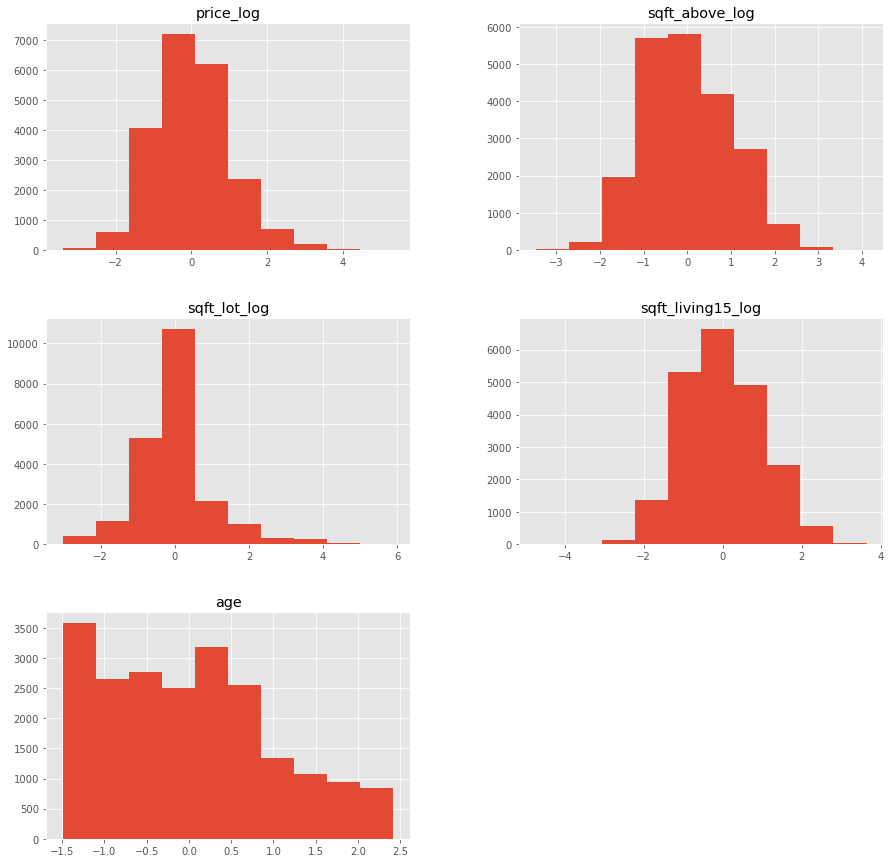

In [764]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [765]:
#drop previous values
clean.drop(['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'age'], axis = 1, inplace = True)

In [766]:
#add the newly standardized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [767]:
#review
clean.head()

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,zip_H,zip_I,zipcode,lat,long,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,age
15937,268950.0,880,8100,1000,8100,3,1.00,1.0,0,1,...,0,0,98166,47.4697,-122.351,-1.044412,-1.443346,0.011001,-1.932101,0.955962
20963,399900.0,900,1005,1440,1188,2,1.75,1.5,0,1,...,0,0,98027,47.5446,-122.018,-0.288860,-1.390746,-2.297864,-0.818484,-1.357975
7614,339000.0,720,4128,1510,4538,3,1.00,1.0,0,1,...,0,0,98126,47.5296,-122.379,-0.603535,-1.913036,-0.734773,-0.673521,0.989991
3257,380000.0,840,7372,1930,5150,2,1.00,1.0,0,1,...,0,0,98126,47.5285,-122.378,-0.386080,-1.552231,-0.093192,0.075960,1.092076
16723,365000.0,1600,4168,1190,4168,5,2.00,1.5,0,0,...,0,0,98126,47.5297,-122.381,-0.462787,-0.044048,-0.724104,-1.400849,1.500418


In [768]:
clean.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'zipcode', 'lat', 'long',
       'price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
       'age'],
      dtype='object')

# MODEL 1: USING STEPWISE SELECTION
## WITHOUT LOCATION FEATURES

In [769]:
#including all log-transformed standardized features without neighborhood information
preprocessed_log_1 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0']]

* If the response variable, y, is log-transformed and assuming we have one predictor, a unit increase in the predictor x is associated with the x’s coefficient, call it b1, (b1*100) percentage increase in y.
* If the predictor is log-transformed(e.g., log(x)), then one unit increase of x means a (b1/100) percent increase in y.
* If both the response and the predictor is log-transformed then a one percent increase in x means a b1 percent increase in y.

In [770]:
preprocessed_log_1.shape

(21420, 14)

In [771]:
#specify X_train and y_train
X = preprocessed_log_1.drop(['price_log'], axis = 1)
y = preprocessed_log_1['price_log']

## Perform Stepwise Selection

In [772]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [773]:
#apply function
result_1 = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_1)

Add  sqft_above_log                 with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  age                            with p-value 3.93411e-295
Add  sqft_living15_log              with p-value 3.29016e-297
Add  floors                         with p-value 1.43352e-207
Add  bathrooms                      with p-value 6.93609e-106
Add  water_1.0                      with p-value 1.82323e-102
Add  bedrooms                       with p-value 6.45593e-80
Add  sqft_lot_log                   with p-value 2.3291e-65
Add  cond_5.0                       with p-value 9.47873e-21
Add  cond_2.0                       with p-value 2.47298e-16
Add  reno_1.0                       with p-value 0.0020841
Add  cond_3.0                       with p-value 0.000490444
Resulting Features:
['sqft_above_log', 'base_1.0', 'age', 'sqft_living15_log', 'floors', 'bathrooms', 'water_1.0', 'bedrooms', 'sqft_lot_log', 'cond_5.0', 'cond_2.0', 'reno_1.0', 'cond_3.0']


Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

**Features that satified p-value requirement:** 'sqft_above_log', 'base_1.0', 'age', 'sqft_living15_log', 'floors', 'bathrooms', 'water_1.0', 'bedrooms', 'sqft_lot_log', 'cond_5.0', 'cond_2.0', 'reno_1.0', 'cond_3.0'

The null hypothesis H0 for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject H0. All of the p-values indicate that all of the current features are substantially influential.

In [774]:
#check out how many features satisfy p < 0.05
len(result_1)

13

## Build Model in Statsmodels

In [775]:
#build initial model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_1]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_1 = sm.OLS(y, X_intercept).fit() 

#get summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2309.
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:17:31   Log-Likelihood:                -21008.
No. Observations:               21420   AIC:                         4.204e+04
Df Residuals:                   21406   BIC:                         4.216e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5127      0.032    -16.074      0.000      -0.575      -0.450
sqft_above_log        0.4650      0.010     47.230      0.000       0.446       0.484
base_1.0              0.4944      0.012     42.524      0.000       0.472       0.517
age                   0.2908      0.006     47.429      0.000       0.279       0.303
sqft_living15_log     0.3055      0.007     44.513      0.000       0.292       0.319
floors                0.1664      0.012     13.370      0.000       0.142       0.191
bathrooms             0.2348      0.010     22.888      0.000       0.215       0.255
water_1.0             1.1534      0.054     21.273      0.000       1.047       1.260
bedrooms             -0.1250      0.006    -19.727      0.000      -0.137      -0.113
sqft_lot_log         -0.0940      0.006    -16.841      0.000      -0.105      -0.083
cond_5.0              0.1380      0.018      7.596      0.000       0.102       0.174
cond_2.0             -0.4387      0.052     -8.503      0.000      -0.540      -0.338
reno_1.0              0.0896      0.026      3.507      0.000       0.040       0.140
cond_3.0             -0.0386      0.011     -3.486      0.000      -0.060      -0.017
==============================================================================
Omnibus:                       10.212   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.186
Skew:                           0.000   Prob(JB):                      0.00372
Kurtosis:                       3.112   Cond. No.                         56.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* We have a JB (goodness-of-fit test) value = 11, which is low and our error is in favor of normality. 
* p-value of 0.006 which rejects H0 of normality.
* All of the features p-values indicate that all of the current features are substantially influential.
* Kurtosis is <3, which indicates we do not have heavier tails. Our error is mesokuric. 
* The skewness value of 0 shows that underlying error is symmetrical. 

In [776]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_1], y)

#predict yhat using our model
yhat = linreg.predict(X[result_1])
yhat

array([-1.01506399, -0.7220789 , -0.73042222, ..., -0.46449712,
        0.10219922,  0.02776517])

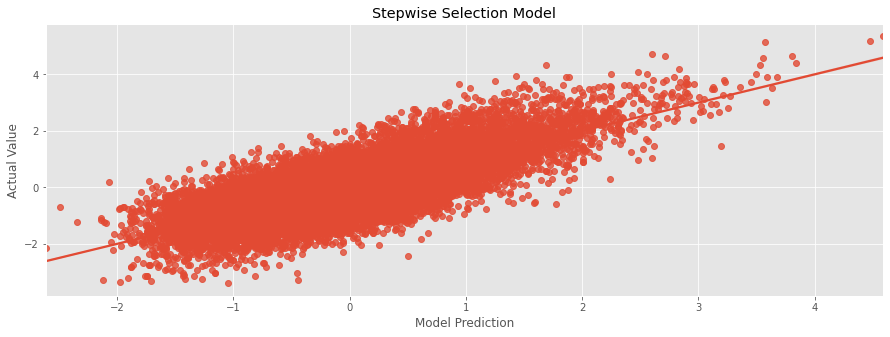

In [777]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y)
plt.title('Stepwise Selection Model')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_1_scatterplot')

In [778]:
#get intercept
linreg.intercept_

-0.5127101416607601

The slope is -0.51, which means there are some features that can negatively impact the price.

In [779]:
#get coefficients and sort them
coefficients = dict(zip(X[result_1], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'cond_2.0': -0.4386768466391749,
 'bedrooms': -0.12495688399490334,
 'sqft_lot_log': -0.09399042723439169,
 'cond_3.0': -0.03859435957635621,
 'reno_1.0': 0.08957564206814196,
 'cond_5.0': 0.13803274011785896,
 'floors': 0.16638788736978852,
 'bathrooms': 0.23479435399219203,
 'age': 0.2908139584311457,
 'sqft_living15_log': 0.3054837585185849,
 'sqft_above_log': 0.465029875211388,
 'base_1.0': 0.49438025937317626,
 'water_1.0': 1.1534400283879966}

**Features that decreases value of the home:**

* 'cond_2.0': -0.4386768466391749,
* 'bedrooms': -0.12495688399490334,
* 'sqft_lot_log': -0.09399042723439169,
* 'cond_3.0': -0.03859435957635621,

**Features that increases value of the home:**
* 'reno_1.0': 0.08957564206814196,
* 'cond_5.0': 0.13803274011785896,
* 'floors': 0.16638788736978852,
* 'bathrooms': 0.23479435399219203,
* 'age': 0.2908139584311457,
* 'sqft_living15_log': 0.3054837585185849,
* 'sqft_above_log': 0.465029875211388,
* 'base_1.0': 0.49438025937317626,
* 'water_1.0': 1.1534400283879966

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables (features X) within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

VIF quantifies how much the variance is inflated.

In [780]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_log_1[result_1]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(result_1, vif))

[('sqft_above_log', 3.0604690655923914),
 ('base_1.0', 2.647755566628498),
 ('age', 1.790770894754111),
 ('sqft_living15_log', 2.420880383094319),
 ('floors', 14.353688084287965),
 ('bathrooms', 23.727457948474726),
 ('water_1.0', 1.030213928249951),
 ('bedrooms', 16.570973396111693),
 ('sqft_lot_log', 1.4146442596012243),
 ('cond_5.0', 1.3336727899987602),
 ('cond_2.0', 1.0336038147780997),
 ('reno_1.0', 1.1525935915616632),
 ('cond_3.0', 3.8930254894975067)]

While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables. One recommendation is that if VIF is greater than 5, then a feature is highly collinear with the other features, and the parameter estimates will have large standard errors because of this. We see here those 'problematic' features are:

* 'floors', 14.353688084287965
* 'bathrooms', 23.727457948474726
* 'bedrooms', 16.570973396111693

Let's recheck for multicollinearity.

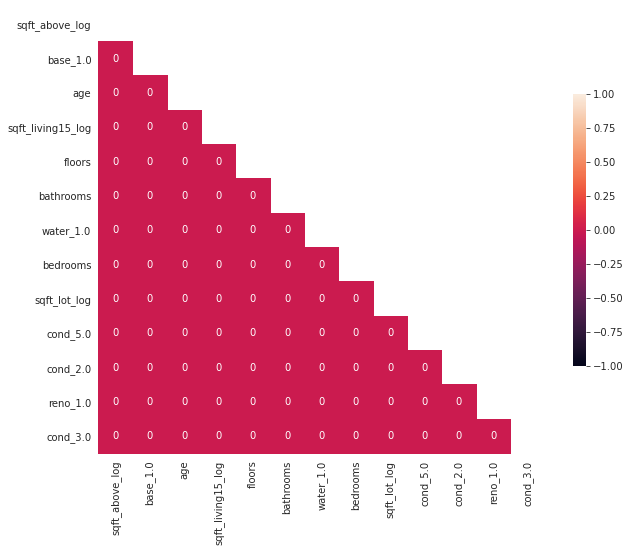

In [781]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_1].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_1].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/model_1_multicollinarity_check')

None of the features are highly correlated. We can safely move on.

**Recheck for normality**

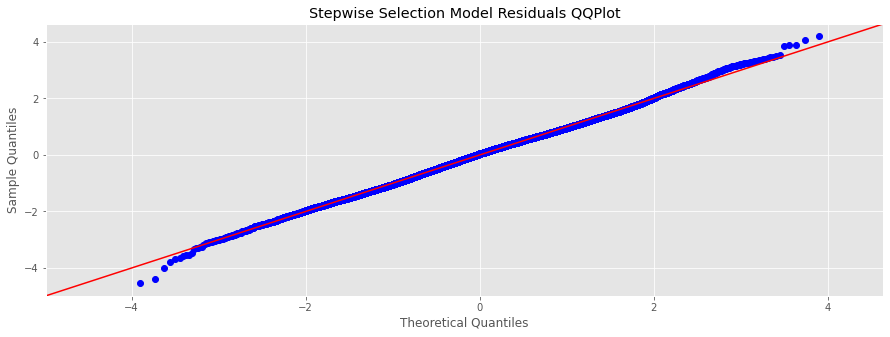

<Figure size 432x288 with 0 Axes>

In [782]:
#recheck for normality
fig = sm.graphics.qqplot(model_1.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Stepwise Selection Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_1_residuals_qqplot')

Assumption of residual normality is satisfied.

**Recheck for homoscedasticity**

Goldfeld-Quandt test examines whether the residual variance is the same in 2 subsamples.

In [783]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_1.resid, model_1.model.exog)
list(zip(name, test))

[('F statistic', 1.0697320299524764), ('p-value', 0.0002457789986660285)]

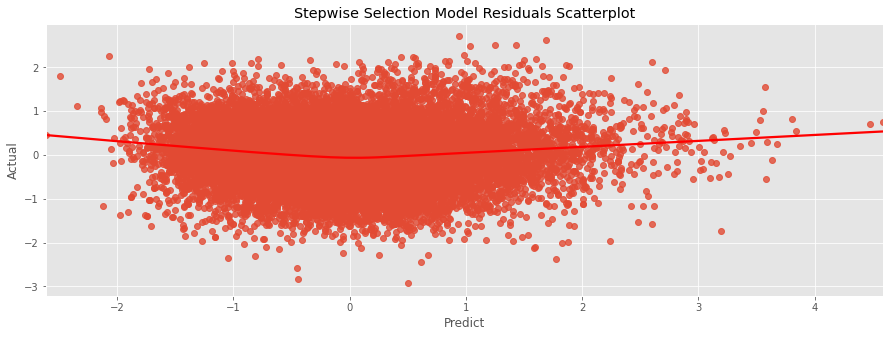

<Figure size 432x288 with 0 Axes>

In [784]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_1.predict(), 
            y = model_1.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Stepwise Selection Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_1_homoscedasticity_regplot')

* p-value of the H0 that the variance in one y and y_hat is different, p-value < 0.05 hence H0 is rejected. Our variance is constant.
* The shape of residual is a symmetrical 'blob', meaning homoscedastic data is evenly dispersed around the regression line. Assumption of residual homoscedasticity is satisfied.

## Validate Model 1

In [785]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [786]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [787]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [788]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.4181054272655965
0.40936879861851705


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

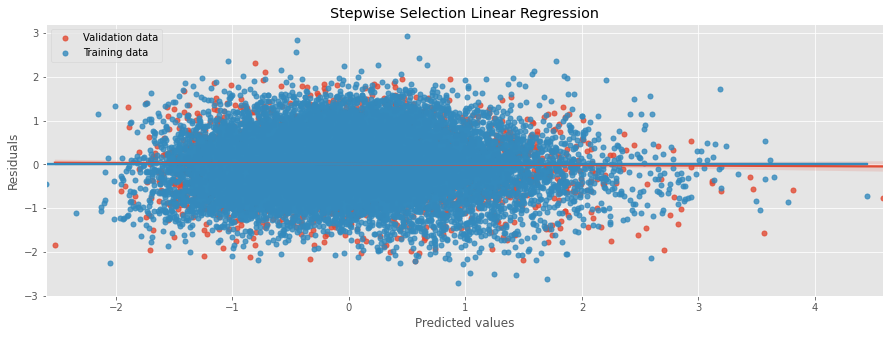

<Figure size 432x288 with 0 Axes>

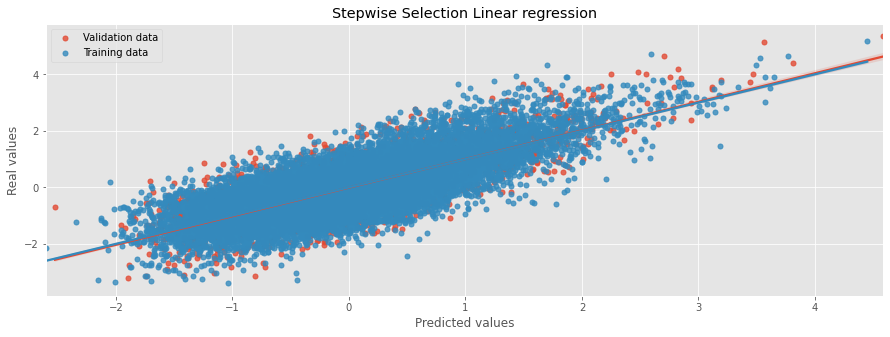

<Figure size 432x288 with 0 Axes>

In [789]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws = {"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws = {"s": 25}, fit_reg = True, label = "Training data")


plt.title("Stepwise Selection Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_1_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws = {"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {"s": 25}, fit_reg = True, label = "Training data")

plt.title("Stepwise Selection Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_1_predictions_regplot')

In [790]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 60%'

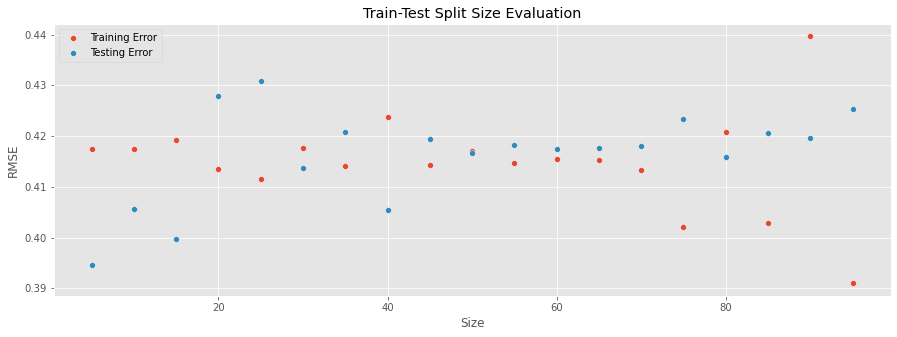

In [791]:
#evaluating the effect of train-test split size (learn.co)
train_err = []
test_err = []
t_sizes = list(range(5,100,5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t_size / 100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
sns.scatterplot(t_sizes, train_err, label = 'Training Error')
sns.scatterplot(t_sizes, test_err, label = 'Testing Error')
plt.title('Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('./Data & Figures/model_1_traintestsplit_scatterplot')

**Recheck for overfitting: K-Fold Cross Validation**

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation. The downside of the train test split is that every time we do a split we obtain a slighlty different result. That's where doing Cross-Validation has a big advantage because with it we're doing a multiple split test and getting the average value from it.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

In [792]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
cv_result

array([-0.42721783, -0.39746253, -0.36374328, -0.41833551, -0.4210369 ,
       -0.41807895, -0.41262473, -0.44186145, -0.43917343, -0.44608678])

In [793]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.4185621389300415

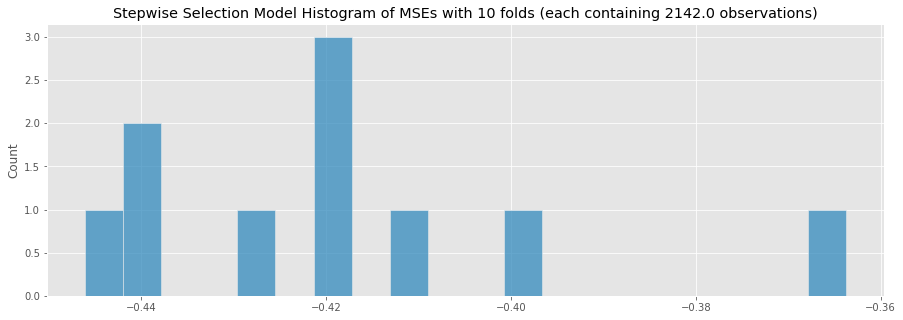

In [794]:
#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Stepwise Selection Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_1) / folds, 0)));
plt.savefig('./Data & Figures/model_1_cv_result_histplot')

The above histogram suggests that even with 10 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted. However, because the cv_result is small, we can be dealing with underfitting. Let's check out bias-variance tradeoff next to see if underfitting is the case.

### Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [795]:
#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [796]:
#fit the model to train data
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

#test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [797]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [798]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: 1.732715019291269e-16 
Train variance: 0.5711228948609128


In [799]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: 0.02730193884052502 
Test variance: 0.566059487093571


### MODEL 1 OBSERVATIONS:

* p = 0 so H0 is rejected
* The model 1's skewness and kurtosis show that our data is symmetrical.
* Performance r2 = 0.60.
* The model does not have multicollinarity.
* The model satisfied normality assumption.
* The model satisfied homoscadasticity assumption.
* The model is not overfitted.

In [800]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_1.pkl','wb'))

In [802]:
#summary table
summary_table_2 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 'Accuracy':[]}
                              
summary_table_2.loc[0] = ['Model 1', 'All except location', len(result_1), accuracy]

SyntaxError: invalid syntax (<ipython-input-802-1519d985bda0>, line 4)

# MODEL REFINEMENT I: 
# USING LOCATION FEATURES

In [710]:
preprocessed_log_2 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 
                            'zipcode', 'lat', 'long']]

preprocessed_log_2.head()

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,-1.044412,-1.443346,0.011001,-1.932101,0.955962,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,98166,47.4697,-122.351
20963,-0.288860,-1.390746,-2.297864,-0.818484,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,-0.603535,-1.913036,-0.734773,-0.673521,0.989991,3,1.00,1.0,0,1,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,-0.386080,-1.552231,-0.093192,0.075960,1.092076,2,1.00,1.0,0,1,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,-0.462787,-0.044048,-0.724104,-1.400849,1.500418,5,2.00,1.5,0,0,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [711]:
preprocessed_log_2.shape

(21420, 26)

In [712]:
X = preprocessed_log_2.drop(['price_log'], axis=1)
y = preprocessed_log_2['price_log']

In [713]:
#apply stepwise function
result_2 = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_2)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  water_1.0                      with p-value 1.75226e-244
Add  lat                            with p-value 3.76129e-161
Add  bedrooms                       with p-value 2.3428e-75
Add  zip_F                          with p-value 2.94707e-55
Add  zipcode                        with p-value 9.38127e-44
Add  zip_H                          with p-value 1.48331e-54
Add  cond_3.0                       with p-value 9.20071e-34
Add  cond_2.0                       with p

In [714]:
#check out how many features satisfy p < 0.05
len(result_2)

24

In [715]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_2]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_1 = sm.OLS(y, X_intercept).fit() 

#get summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     3005.
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:07:28   Log-Likelihood:                -14595.
No. Observations:               21420   AIC:                         2.924e+04
Df Residuals:                   21395   BIC:                         2.944e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                33.9704     14.606      2.326      0.020       5.341      62.600
bathrooms             0.1838      0.008     24.099      0.000       0.169       0.199
age                   0.0984      0.005     18.842      0.000       0.088       0.109
zip_D                -0.2281      0.023     -9.743      0.000      -0.274      -0.182
sqft_above_log        0.4543      0.007     62.136      0.000       0.440       0.469
base_1.0              0.3302      0.009     37.102      0.000       0.313       0.348
zip_A                 0.7039      0.020     36.022      0.000       0.666       0.742
zip_C                 0.6147      0.028     22.155      0.000       0.560       0.669
sqft_living15_log     0.2414      0.005     45.913      0.000       0.231       0.252
zip_B                 0.3865      0.030     12.748      0.000       0.327       0.446
zip_G                 0.5007      0.033     15.306      0.000       0.437       0.565
water_1.0             1.2673      0.040     31.298      0.000       1.188       1.347
lat                   0.8523      0.058     14.788      0.000       0.739       0.965
bedrooms             -0.0830      0.005    -17.525      0.000      -0.092      -0.074
zip_F                -0.4787      0.026    -18.580      0.000      -0.529      -0.428
zipcode              -0.0020      0.000    -15.805      0.000      -0.002      -0.002
zip_H                -0.0887      0.030     -2.916      0.004      -0.148      -0.029
cond_3.0             -0.0868      0.008    -10.356      0.000      -0.103      -0.070
cond_2.0             -0.3937      0.038    -10.283      0.000      -0.469      -0.319
long                 -0.9591      0.061    -15.763      0.000      -1.078      -0.840
zip_I                 0.4927      0.042     11.722      0.000       0.410       0.575
reno_1.0              0.1716      0.019      9.026      0.000       0.134       0.209
sqft_lot_log          0.0427      0.005      9.497      0.000       0.034       0.052
cond_5.0              0.1122      0.014      8.310      0.000       0.086       0.139
floors                0.0342      0.010      3.579      0.000       0.015       0.053
==============================================================================
Omnibus:                      414.263   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.150
Skew:                          -0.039   Prob(JB):                    2.05e-191
Kurtosis:                       3.989   Cond. No.                     4.38e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+08. This might indicate that there are
strong multicollinear

77% of the dataset's variation from the mean can be explained by our model.

With location features included, our r2 increases to 0.766, meaning our Model 2 performs better than our Model 1 (r2 = 0.6, without location features).

* p-value of 0 which rejects H0 of normality.
* All of the features p-values indicate that all of the current features are substantially influential.
* Kurtosis is >3, which indicates we might have slightly heavy tail. Our error is leptokuric. 
* The skewness value of -0.022 shows that underlying error is symmetrical. 

In [716]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_2], y)

#predict yhat using our model
yhat = linreg.predict(X[result_2])
yhat

array([-1.55287481, -0.83077404, -0.5438984 , ..., -0.72428211,
       -0.39552154, -0.6951264 ])

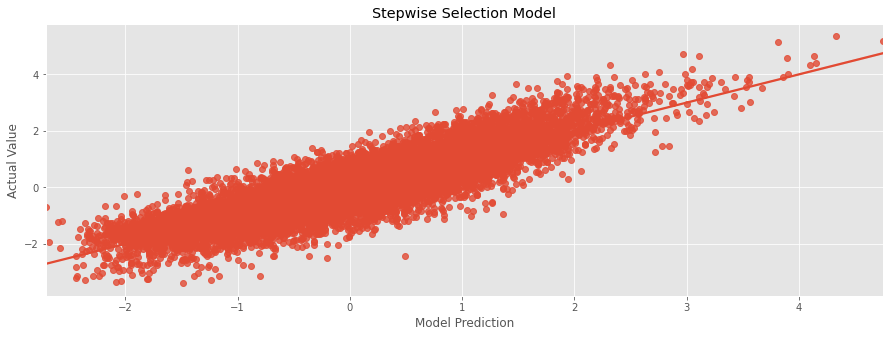

In [717]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y)
plt.title('Stepwise Selection Model')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_2_scatterplot')

In [718]:
#get intercept
linreg.intercept_

33.97036084613901

In [719]:
#get coefficients and sort them
coefficients = dict(zip(X[result_2], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'long': -0.9591188206085244,
 'zip_F': -0.4787367863920883,
 'cond_2.0': -0.3937382776479401,
 'zip_D': -0.2280772371878534,
 'zip_H': -0.08865115809169749,
 'cond_3.0': -0.0867758167172551,
 'bedrooms': -0.08298053183298534,
 'zipcode': -0.0019611372412645725,
 'floors': 0.03417317403252736,
 'sqft_lot_log': 0.042741818884837225,
 'age': 0.09836621681235658,
 'cond_5.0': 0.11220057378206703,
 'reno_1.0': 0.1715549671668893,
 'bathrooms': 0.18382100552527433,
 'sqft_living15_log': 0.24143571589178167,
 'base_1.0': 0.33020529194188825,
 'zip_B': 0.38648009321472376,
 'sqft_above_log': 0.45427270315370316,
 'zip_I': 0.4926621071319839,
 'zip_G': 0.5006535423002815,
 'zip_C': 0.6147001732046423,
 'zip_A': 0.7038750119222076,
 'lat': 0.8523285426270023,
 'water_1.0': 1.2673388000009107}

**Features that lower values:**
* 'zip_F': -0.6514326586001128,
* 'zip_H': -0.4416407647919248,
* 'cond_2.0': -0.4069070060595123,
* 'zip_D': -0.3782179017366077,
* 'cond_3.0': -0.08831031968197017,
* 'bedrooms': -0.08095195254856144,
* 'zipcode': -0.0019000568716221816,

**Features that add values:**
* 'floors': 0.025547212979023542,
* 'sqft_lot_log': 0.03320413784508265,
* 'zip_I': 0.07248640260570391,
* 'age': 0.10358121926221661,
* 'cond_5.0': 0.10680720504969606,
* 'reno_1.0': 0.17082311227412925,
* 'bathrooms': 0.18340874890869127,
* 'sqft_living15_log': 0.24660233582715968,
* 'zip_G': 0.3205190101280872,
* 'base_1.0': 0.3358106675815312,
* 'zip_B': 0.4323371423039727,
* 'sqft_above_log': 0.4543808791035062,
* 'zip_C': 0.5453102684999501,
* 'zip_A': 0.8583790734682855,
* 'water_1.0': 1.3005486620660869

## Test Model 2

**Recheck for multicollinearity, normality, homoscedasticity**

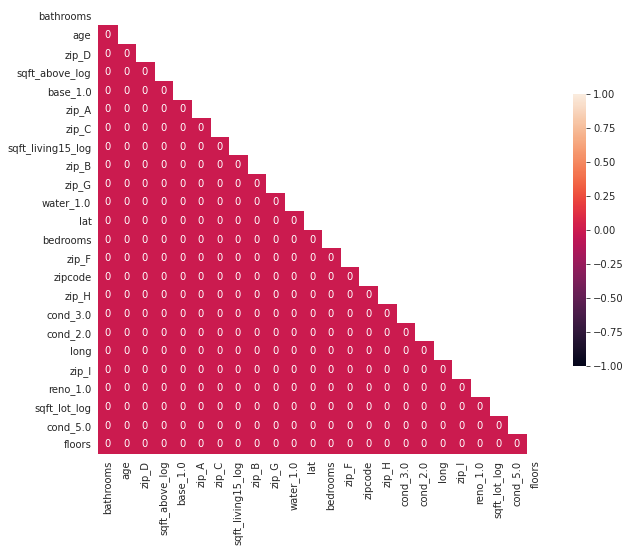

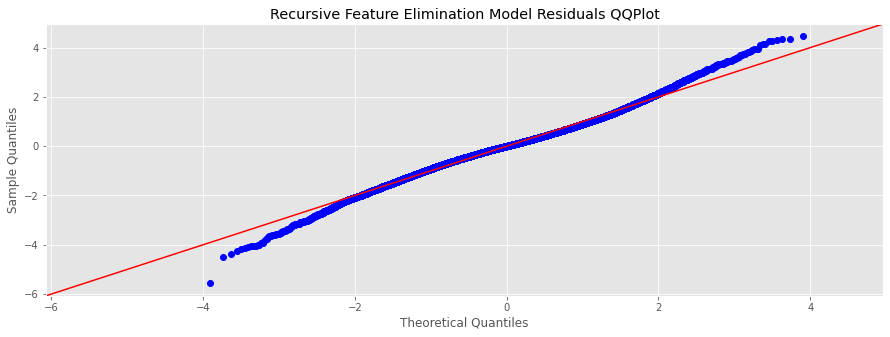

<Figure size 432x288 with 0 Axes>

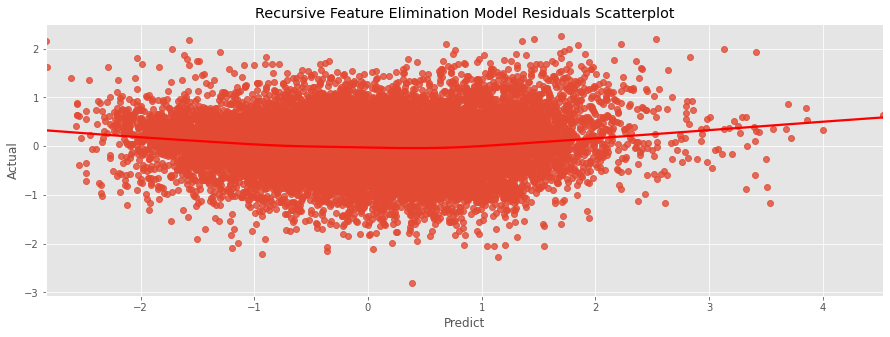

<Figure size 432x288 with 0 Axes>

In [720]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_2].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_2].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)    
plt.savefig('./Data & Figures/model_2_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_2.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Recursive Feature Elimination Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_2_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_2.predict(), 
            y = model_2.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Recursive Feature Elimination Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_2_homoscedasticity_regplot')

In [721]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_2.resid, model_2.model.exog)
list(zip(name, test))

[('F statistic', 1.073374117560438), ('p-value', 0.00012560777585982188)]

## Validate Model 2

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [722]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [723]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [724]:
#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [725]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.23049911811422671
0.22209289043066904


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

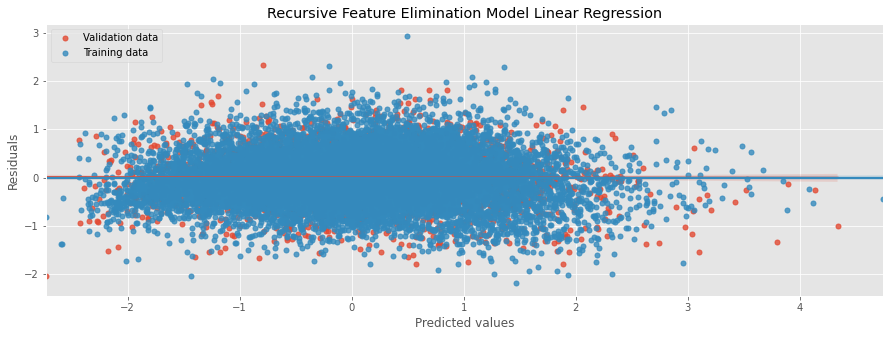

<Figure size 432x288 with 0 Axes>

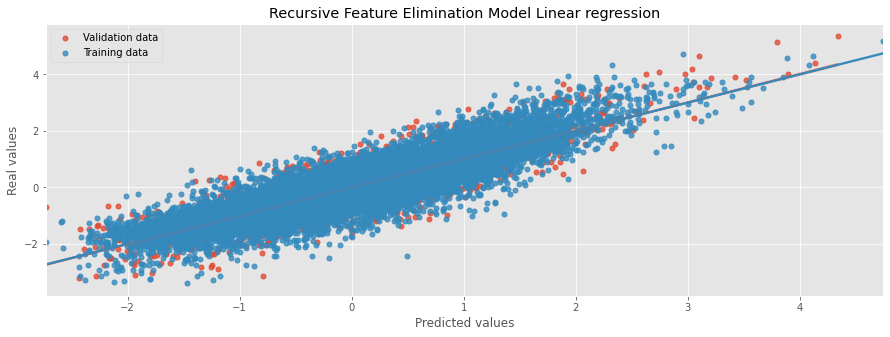

<Figure size 432x288 with 0 Axes>

In [726]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws = {"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws = {"s": 25}, fit_reg = True, label = "Training data")

plt.title("Recursive Feature Elimination Model Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_2_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws = {"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {"s": 25}, fit_reg = True, label = "Training data")

plt.title("Recursive Feature Elimination Model Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_2_predictions_regplot')

In [727]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 78%'

**Recheck for overfitting: K-Fold Cross Validation**

In [728]:
#cross-validation to check for overfitting (learn.co)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
cv_result

array([-0.21695287, -0.2053508 , -0.22029723, -0.2326719 , -0.25555998,
       -0.24878419, -0.22554708, -0.21901194, -0.24653023, -0.25208973])

In [729]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.2322795952048696

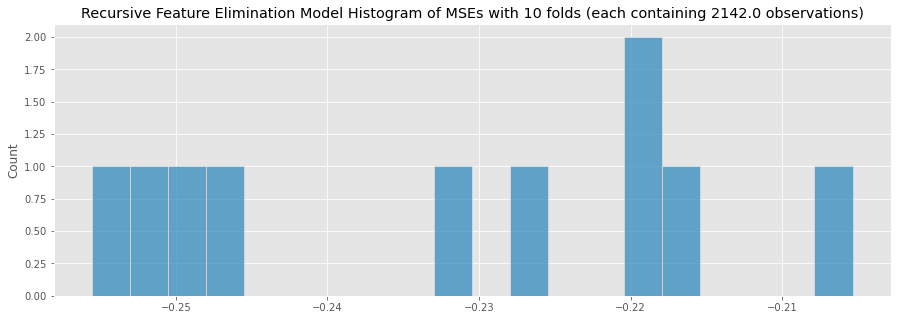

In [730]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Recursive Feature Elimination Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_2) / folds, 0)));
plt.savefig('./Data & Figures/model_2_cv_result_histplot')

The above histogram suggests that with 10 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

### Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [731]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [732]:
#fit the model to train data
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

#test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [733]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: 5.633299874919492e-16 
Train variance: 0.765764028492723


In [734]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: 0.0019426540671841153 
Test variance: 0.7894985122194247


### MODEL 2 OBSERVATIONS:

* p = 0 hence H0 is rejected
* The model skewness and kurtosis shows that our data is symmetrical.
* Performance improves with location features included r2 = 0.76.
* The model does not have multicollinarity.
* The model satisfied normality assumption.
* The model satisfied homoscadasticity assumption.
* The model is not overfitted.
* Bias-variance tradeoff has a big difference.

In [735]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_2.pkl','wb'))

# MODEL REFINEMENT II: 
# RECURSIVE FEATURE RANKING

Stepwise Selection selects features based on p-value. RFE ranks the variable on the basis on linear regression fit.
By combining them, we select for the 10 most important features.

RFE is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [736]:
#create new dataframe
preprocessed_log_3 = preprocessed_log_2.copy(deep = True)

#review
preprocessed_log_3.head()

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,-1.044412,-1.443346,0.011001,-1.932101,0.955962,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,98166,47.4697,-122.351
20963,-0.288860,-1.390746,-2.297864,-0.818484,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,-0.603535,-1.913036,-0.734773,-0.673521,0.989991,3,1.00,1.0,0,1,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,-0.386080,-1.552231,-0.093192,0.075960,1.092076,2,1.00,1.0,0,1,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,-0.462787,-0.044048,-0.724104,-1.400849,1.500418,5,2.00,1.5,0,0,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [737]:
X = preprocessed_log_3.drop(['price_log'], axis=1)
y = preprocessed_log_3['price_log']

In [738]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 10 
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([ True, False, False, False, False, False, False,  True,  True,
        True,  True, False, False, False, False, False,  True,  True,
        True, False,  True, False, False, False,  True])

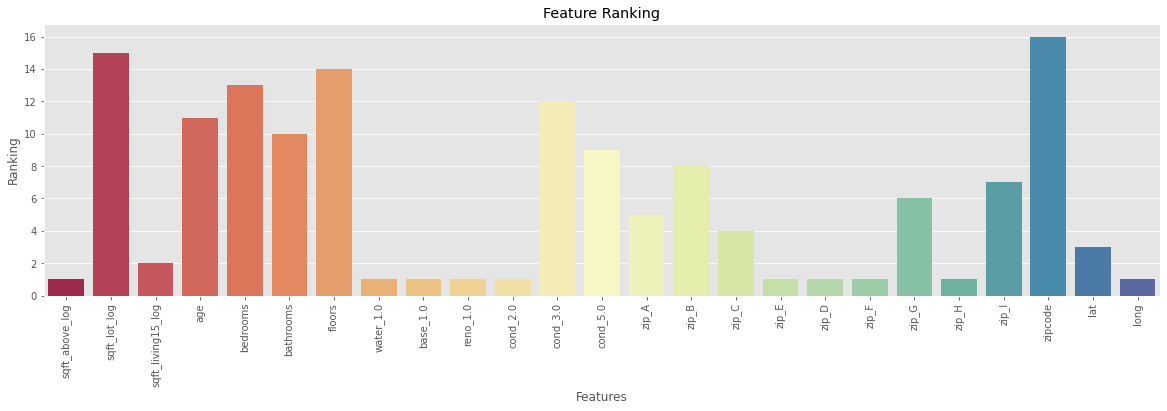

<Figure size 432x288 with 0 Axes>

In [739]:
#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X.columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_3_recursive_features_elimination')

We can see here that the best predictors/ features are 
* 'zipcode'
* 'sqft_lot'
* 'floors'
* 'bedrooms'
* 'cond_3.0', 'cond_5.0'
* 'age'
* 'zip_B'
* 'zip_I'
* 'zip_G'
* 'zip_A'
* 'zip_C'

In [740]:
#fit the linear regression model again using the selected columns
selected_features = X.columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

In [741]:
#get coefficients and sort them
coefficients = dict(zip(X[selected_features], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'zip_F': -1.3085309870142532,
 'long': -1.0752963364434478,
 'zip_D': -1.0079423514861188,
 'zip_E': -0.9833768685447112,
 'zip_H': -0.8457267449145074,
 'cond_2.0': -0.30648122323952304,
 'reno_1.0': 0.24571952863242744,
 'base_1.0': 0.514439613795257,
 'sqft_above_log': 0.6645284025761439,
 'water_1.0': 1.4950192163035592}

In [742]:
#build model in statsmodels

#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_3 = sm.OLS(y, X_intercept).fit() 

#get summary
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     5509.
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:07:48   Log-Likelihood:                -16754.
No. Observations:               21420   AIC:                         3.353e+04
Df Residuals:                   21409   BIC:                         3.362e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -131.3353      3.713    -35.370      0.000    -138.613    -124.057
sqft_above_log     0.6645      0.004    167.349      0.000       0.657       0.672
water_1.0          1.4950      0.044     33.642      0.000       1.408       1.582
base_1.0           0.5144      0.008     65.822      0.000       0.499       0.530
reno_1.0           0.2457      0.020     12.317      0.000       0.207       0.285
cond_2.0          -0.3065      0.042     -7.318      0.000      -0.389      -0.224
zip_E             -0.9834      0.015    -63.687      0.000      -1.014      -0.953
zip_D             -1.0079      0.014    -72.535      0.000      -1.035      -0.981
zip_F             -1.3085      0.014    -94.491      0.000      -1.336      -1.281
zip_H             -0.8457      0.015    -55.584      0.000      -0.876      -0.816
long              -1.0753      0.030    -35.386      0.000      -1.135      -1.016
==============================================================================
Omnibus:                      512.950   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.376
Skew:                           0.141   Prob(JB):                    8.20e-229
Kurtosis:                       4.048   Cond. No.                     1.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With recursive feature ranking selecting 10 best features, our r2 decreases to 0.72, our Model 2 performs worse than our Model 2 (r2 = 0.77).

72% of the dataset variation from the mean can be explained by our Model 3.

* p-value of 0 which rejects H0 of normality.
* All of the features p-values indicate that all of the current features are substantially influential.
* Kurtosis is >3, which indicates we might have slightly heavy tail. Our error is leptokuric. 
* The skewness value of ~0 shows that underlying error is symmetrical. 

In [743]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_3.pkl','wb'))

## MODEL REFINEMENT III: 
## INTERACTION

### See how interactions improve our baseline

In [744]:
#create new dataframe
preprocessed_log_4 = preprocessed_log_2.copy(deep = True)

#review
preprocessed_log_4.head(2)

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,zip_C,zip_E,zip_D,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,-1.044412,-1.443346,0.011001,-1.932101,0.955962,3,1.00,1.0,0,1,...,0,1,0,0,0,0,0,98166,47.4697,-122.351
20963,-0.288860,-1.390746,-2.297864,-0.818484,-1.357975,2,1.75,1.5,0,1,...,0,0,0,0,1,0,0,98027,47.5446,-122.018


In [745]:
#drop 'zipcode', 'lat', and 'long' since we already have dummies for them
preprocessed_log_4.drop(['zipcode', 'lat', 'long', 'zip_E'], axis = 1, inplace = True)

#review
preprocessed_log_4.head(2)

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,cond_3.0,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_F,zip_G,zip_H,zip_I
15937,-1.044412,-1.443346,0.011001,-1.932101,0.955962,3,1.00,1.0,0,1,...,1,0,0,0,0,0,0,0,0,0
20963,-0.288860,-1.390746,-2.297864,-0.818484,-1.357975,2,1.75,1.5,0,1,...,1,0,0,0,0,0,0,1,0,0


In [746]:
#define training variables
X = preprocessed_log_4.drop(['price_log'], axis = 1)
y = preprocessed_log_4['price_log']

In [747]:
#get baseline model r2
from sklearn.model_selection import KFold

regression = LinearRegression()

crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

baseline = np.mean(cross_val_score(regression, X, y, scoring = 'r2', cv = crossvalidation))
baseline

0.7624759217847974

Create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the  𝑅2 . We'll look at the 3 interactions which have the biggest effect on our  𝑅2 , so print out the top 3 combinations.

In [748]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv = crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 10 interactions: %s' %sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10])

0
50
100
150
200
Top 10 interactions: [('sqft_living15_log', 'zip_C', 0.767), ('sqft_above_log', 'bathrooms', 0.766), ('sqft_lot_log', 'zip_A', 0.766), ('sqft_lot_log', 'zip_C', 0.765), ('sqft_above_log', 'sqft_lot_log', 0.764), ('sqft_above_log', 'sqft_living15_log', 0.764), ('sqft_above_log', 'zip_C', 0.764), ('sqft_lot_log', 'age', 0.764), ('sqft_lot_log', 'bathrooms', 0.764), ('sqft_lot_log', 'zip_H', 0.764)]


In [749]:
#check how many pairs of interaction there are
len(interactions)

121

In [750]:
interactions[:10]

[('sqft_above_log', 'sqft_lot_log', 0.764),
 ('sqft_above_log', 'sqft_living15_log', 0.764),
 ('sqft_above_log', 'age', 0.763),
 ('sqft_above_log', 'bedrooms', 0.763),
 ('sqft_above_log', 'bathrooms', 0.766),
 ('sqft_above_log', 'floors', 0.763),
 ('sqft_above_log', 'water_1.0', 0.762),
 ('sqft_above_log', 'base_1.0', 0.763),
 ('sqft_above_log', 'cond_3.0', 0.763),
 ('sqft_above_log', 'zip_A', 0.763)]

In [751]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
X_interactions = X.copy()

X_interactions['sqft_living15_log * zip_C'] = X_interactions['sqft_living15_log'] * X_interactions['zip_C']
X_interactions['sqft_above_log * bathrooms'] = X_interactions['sqft_above_log'] * X_interactions['bathrooms']
X_interactions['sqft_lot_log * zip_A'] = X_interactions['sqft_lot_log'] * X_interactions['zip_A']
X_interactions['sqft_lot_log * zip_C'] = X_interactions['sqft_lot_log'] * X_interactions['zip_C']
X_interactions['sqft_above_log * sqft_lot_log'] = X_interactions['sqft_above_log'] * X_interactions['sqft_lot_log']
X_interactions['sqft_above_log * sqft_living15_log'] = X_interactions['sqft_above_log'] * X_interactions['sqft_living15_log']
X_interactions['sqft_above_log * zip_C'] = X_interactions['sqft_above_log'] * X_interactions['zip_C']
X_interactions['sqft_lot_log * age'] = X_interactions['sqft_lot_log'] * X_interactions['age']
X_interactions['sqft_lot_log * bathrooms'] = X_interactions['sqft_lot_log'] * X_interactions['bathrooms']
X_interactions['sqft_lot_log * zip_H'] = X_interactions['sqft_lot_log'] * X_interactions['zip_H']

interaction_model = np.mean(cross_val_score(regression, X_interactions, y, scoring = 'r2', cv = crossvalidation))

interaction_model

0.7757566230407427

In [752]:
#apply stepwise function
result_4 = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_4)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  water_1.0                      with p-value 1.75226e-244
Add  zip_F                          with p-value 9.15729e-135
Add  sqft_living15_log * zip_C      with p-value 7.58816e-73
Add  zip_I                          with p-value 1.7845e-76
Add  bedrooms                       with p-value 5.61935e-61
Add  sqft_lot_log * zip_A           with p-value 2.37644e-44
Add  sqft_above_log * bathrooms     with p-value 5.35246e-53
Add  cond_3.0                       with p

In [753]:
#create model in OLS
X_int = sm.add_constant(X_interactions)
model_4 = sm.OLS(y, X_interactions).fit()

model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.770
Method:                 Least Squares   F-statistic:                              2311.
Date:                Mon, 25 Jan 2021   Prob (F-statistic):                        0.00
Time:                        02:08:15   Log-Likelihood:                         -14649.
No. Observations:               21420   AIC:                                  2.936e+04
Df Residuals:                   21389   BIC:                                  2.961e+04
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
sqft_above_log                         0.4304      0.012     35.812      0.000       0.407       0.454
sqft_lot_log                           0.0010      0.014      0.069      0.945      -0.026       0.028
sqft_living15_log                      0.2226      0.006     39.364      0.000       0.211       0.234
age                                    0.0446      0.006      8.062      0.000       0.034       0.055
bedrooms                              -0.1232      0.004    -29.048      0.000      -0.132      -0.115
bathrooms                              0.0790      0.008     10.465      0.000       0.064       0.094
floors                                -0.1368      0.009    -15.002      0.000      -0.155      -0.119
water_1.0                              1.2935      0.041     31.749      0.000       1.214       1.373
base_1.0                               0.3673      0.009     40.721      0.000       0.350       0.385
reno_1.0                               0.2260      0.019     11.815      0.000       0.189       0.264
cond_2.0                              -0.4647      0.038    -12.084      0.000      -0.540      -0.389
cond_3.0                              -0.1528      0.008    -18.527      0.000      -0.169      -0.137
cond_5.0                               0.1088      0.014      8.030      0.000       0.082       0.135
zip_A                                  0.6895      0.014     47.891      0.000       0.661       0.718
zip_B                                  0.5098      0.015     34.050      0.000       0.480       0.539
zip_C                                  0.5075      0.016     31.006      0.000       0.475       0.540
zip_D                                 -0.3418      0.017    -20.417      0.000      -0.375      -0.309
zip_F                                 -0.5502      0.017    -33.202      0.000      -0.583      -0.518
zip_G                                  0.4133      0.017     24.189      0.000       0.380       0.447
zip_H                                 -0.3932      0.018    -21.656      0.000      -0.429      -0.358
zip_I                                  0.1398      0.023      5.994      0.000       0.094       0.185
sqft_living15_log * zip_C              0.1986      0.014     13.713      0.000       0.170       0.227
sqft_above_log * bathrooms             0.0754      0.005     15.180      0.000       0.066       0.085
sqft_lot_log * zip_A                  -0.1951      0.011    -17.651      0.000      -0.217      -0.173
sqft_lot_log * zip_C                   0.1556      0.017      9.163      0.000       0.122       0.189
sqft_above_log * sqft_lot_log         -0.0123      0.005     -2.482      0.013      -0.022      -0.0

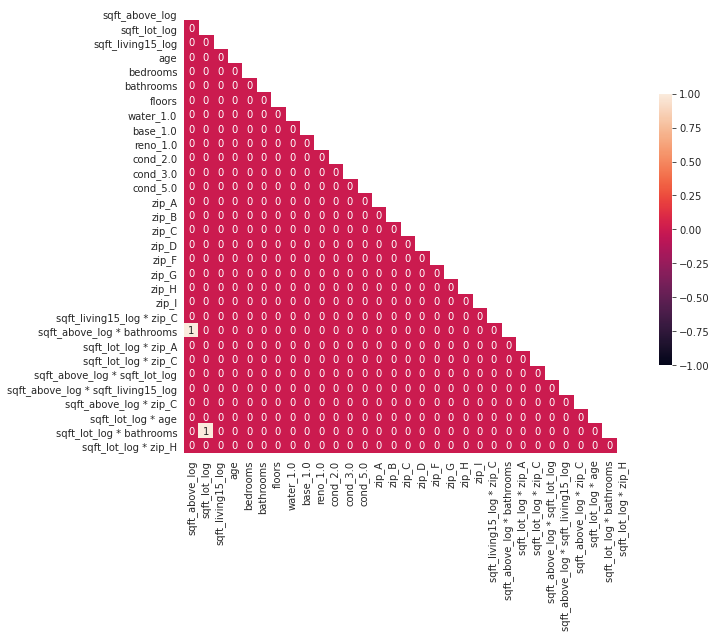

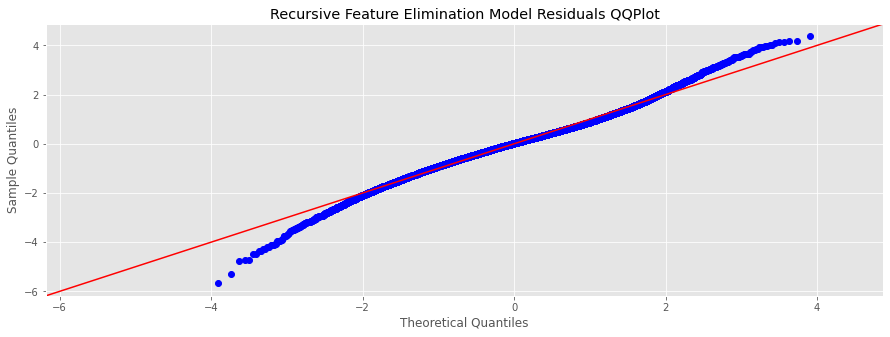

<Figure size 432x288 with 0 Axes>

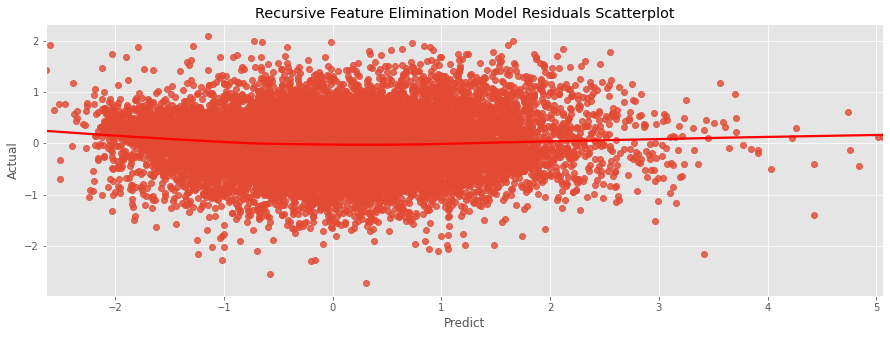

<Figure size 432x288 with 0 Axes>

In [754]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions.corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions.corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)    
plt.savefig('./Data & Figures/model_4_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_4.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Recursive Feature Elimination Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_4_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_4.predict(), 
            y = model_4.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Recursive Feature Elimination Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_4_homoscedasticity_regplot')

In [755]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_4.resid, model_4.model.exog)
list(zip(name, test))

[('F statistic', 1.0919908314171898), ('p-value', 2.730957662851444e-06)]

In [756]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

17136 17136 4284 4284
0.23812307419486492
0.23084773632628955


-0.2392099241434627


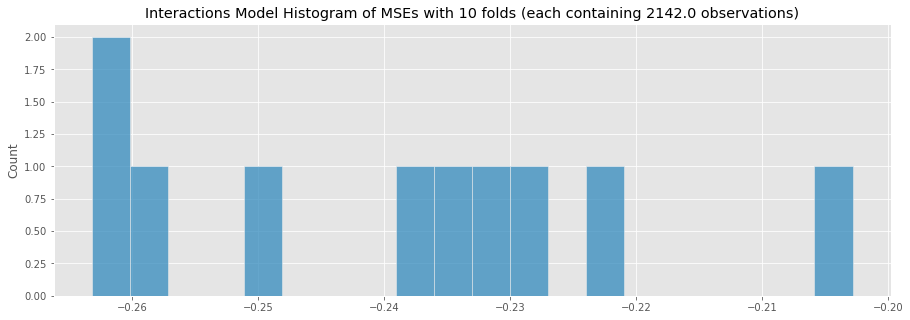

In [757]:
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Interactions Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_1) / folds, 0)));
plt.savefig('./Data & Figures/model_4_cv_result_histplot')

In [758]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_4.pkl','wb'))